In [1]:
# CERES: https://ceres.larc.nasa.gov/products.php?product=SYN1deg
# https://ceres.larc.nasa.gov/documents/ATBD/pdf/r2_2/ceres-atbd2.2-s7.0.pdf

In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime, timedelta
%matplotlib inline

In [3]:
ceres = xr.open_dataset('/home/jovyan/CERES_SYN1deg-1H_Terra-Aqua-MODIS_Ed4A_Subset_20101001-20170831.nc')
cues = xr.open_dataset('/home/jovyan/cues/summa_setup/forcings/cues_2011-2017.nc')

In [4]:
cues['time'] = cues.time.values + np.timedelta64(8,'h') # CUES is in PST, add 8 hours to make it UTC

In [5]:
# set our simulation start/finish times
start = '2010-10-01 12:00' # simulation start time ( had to move this forward 12 hrs to get datasets to line up)
finish = '2017-08-01 22:40' # simulation end time (had to set this to 40 min to get the two data sets to line up, they're 30 min apart)

# create new forcing data set starting with original CUES for this time period
cues_time_window = cues.loc[dict(time=slice(start, finish))]
ceres_time_window = ceres.loc[dict(time=slice(start, finish))]


In [6]:
# replace the CUES LW and SW with CERES LW and SW
new_forcing_data = cues_time_window.copy(data={'airpres': cues_time_window.airpres,
                                               'airtemp': cues_time_window.airtemp,
                                               'spechum': cues_time_window.spechum,
                                               'windspd': cues_time_window.windspd,
                                               'LWRadAtm': ceres_time_window.adj_atmos_lw_down_all_surface_1h[:,:,0],
                                               'SWRadAtm': ceres_time_window.adj_atmos_sw_down_all_surface_1h[:,:,0],
                                               'pptrate': cues_time_window.pptrate,
                                               'hruId': cues_time_window.hruId,
                                               'latitude': cues_time_window.latitude,
                                               'longitude': cues_time_window.longitude,
                                               'data_step': cues_time_window.data_step
                                              },deep=True)

# take a look at the structure of this new dataset
new_forcing_data

<xarray.Dataset>
Dimensions:    (hru: 1, time: 59915)
Coordinates:
  * time       (time) datetime64[ns] 2010-10-01T12:00:00 ... 2017-08-01T22:00:00
Dimensions without coordinates: hru
Data variables:
    airpres    (time, hru) float64 7.2e+04 7.203e+04 ... 7.23e+04 7.23e+04
    airtemp    (time, hru) float64 285.1 284.8 286.1 287.5 ... 298.4 296.3 296.1
    spechum    (time, hru) float64 0.004844 0.004598 ... 0.005626 0.005558
    windspd    (time, hru) float64 0.87 0.95 0.4 0.4 ... 1.08 1.52 1.59 1.85
    SWRadAtm   (time, hru) float32 0.0 0.0 57.1 ... 733.475 641.075 594.675
    LWRadAtm   (time, hru) float32 332.925 324.175 319.65 ... 424.125 422.35
    pptrate    (time, hru) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    hruId      (hru) int32 1001
    latitude   (hru) float64 41.9
    longitude  (hru) float64 13.61
    data_step  float64 3.6e+03

In [7]:
# save this new forcing data out to a new .nc file
new_forcing_data.to_netcdf('/home/jovyan/cues/summa_setup/forcings/forcings_cues-ceres_2011-2017.nc', mode='w')

/srv/conda/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


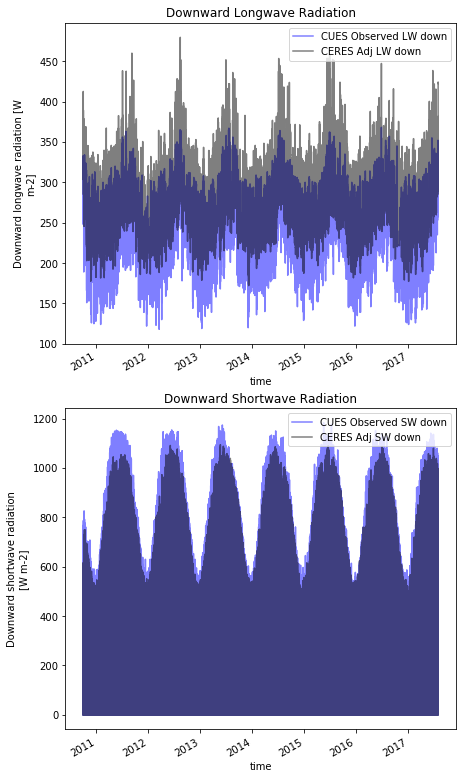

In [7]:
# open this new forcing data and compare against our original:
cues_ceres = xr.open_dataset('/home/jovyan/cues/summa_setup/forcings/forcings_cues-ceres_2011-2017.nc')

# plots
fig, [ax1, ax2] = plt.subplots(2,1,figsize=(7,13))
cues_time_window.LWRadAtm.plot(ax=ax1, color='b',linestyle='-',alpha=0.5,label='CUES Observed LW down')
cues_ceres.LWRadAtm.plot(ax=ax1,color='k',linestyle='-',alpha=0.5,label='CERES Adj LW down')
ax1.set_title('Downward Longwave Radiation')
ax1.legend()
cues_time_window.SWRadAtm.plot(ax=ax2, color='b',linestyle='-',alpha=0.5,label='CUES Observed SW down')
cues_ceres.SWRadAtm.plot(ax=ax2,color='k',linestyle='-',alpha=0.5,label='CERES Adj SW down')
ax2.set_title('Downward Shortwave Radiation')
ax2.legend();

fig.savefig('LW_SW_Rad_timeline.png',dpi=600)

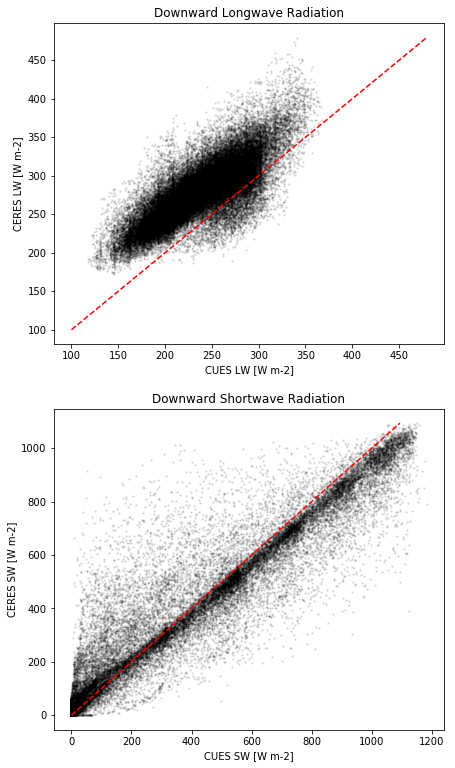

In [11]:
# 1-to-1 plots
fig, [ax1, ax2] = plt.subplots(2,1,figsize=(7,13))
ax1.scatter(cues_time_window.LWRadAtm.values,cues_ceres.LWRadAtm.values,c='k',s=2,alpha=0.1)
ax1.plot([100,np.max(cues_ceres.LWRadAtm.values)],
         [100,np.max(cues_ceres.LWRadAtm.values)],'--r')
ax1.set_title('Downward Longwave Radiation')
ax1.set_xlabel('CUES LW [W m-2]');
ax1.set_ylabel('CERES LW [W m-2]');

ax2.scatter(cues_time_window.SWRadAtm.values,cues_ceres.SWRadAtm.values,c='k',s=2,alpha=0.1)
ax2.plot([0,np.max(cues_ceres.SWRadAtm.values)],
         [0,np.max(cues_ceres.SWRadAtm.values)],'--r')
ax2.set_title('Downward Shortwave Radiation')
ax2.set_xlabel('CUES SW [W m-2]');
ax2.set_ylabel('CERES SW [W m-2]');

fig.savefig('1-to-1_plots.png',dpi=600)

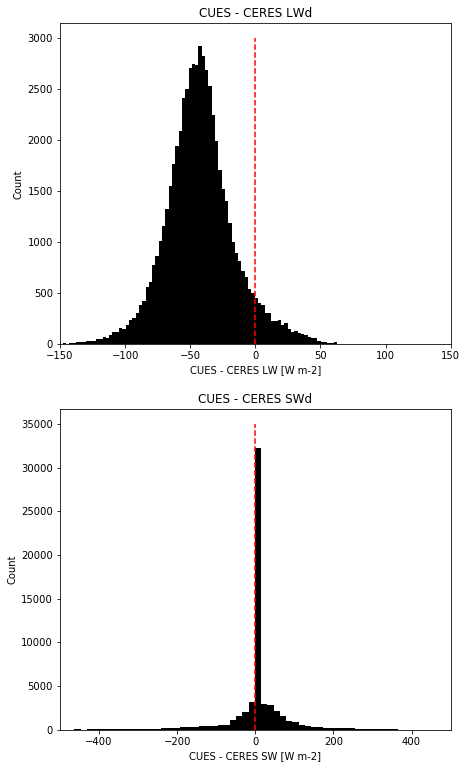

In [32]:
# difference histogram plots
fig, [ax1, ax2] = plt.subplots(2,1,figsize=(7,13))
ax1.hist(cues_time_window.LWRadAtm.values - cues_ceres.LWRadAtm.values,bins=100,color='k')
ax1.plot([0,0],
         [0,3000],'--r')
ax1.set_xlim((-150,150))
ax1.set_title('CUES - CERES LWd')
ax1.set_xlabel('CUES - CERES LW [W m-2]');
ax1.set_ylabel('Count');

ax2.hist(cues_time_window.SWRadAtm.values - cues_ceres.SWRadAtm.values,bins=100,color='k')
ax2.plot([0,0],
         [0,35000],'--r')
ax2.set_xlim((-500,500))
#ax2.set_yscale('log')
ax2.set_title('CUES - CERES SWd')
ax2.set_xlabel('CUES - CERES SW [W m-2]');
ax2.set_ylabel('Count');

fig.savefig('diff_hist_plots.png',dpi=600)

***

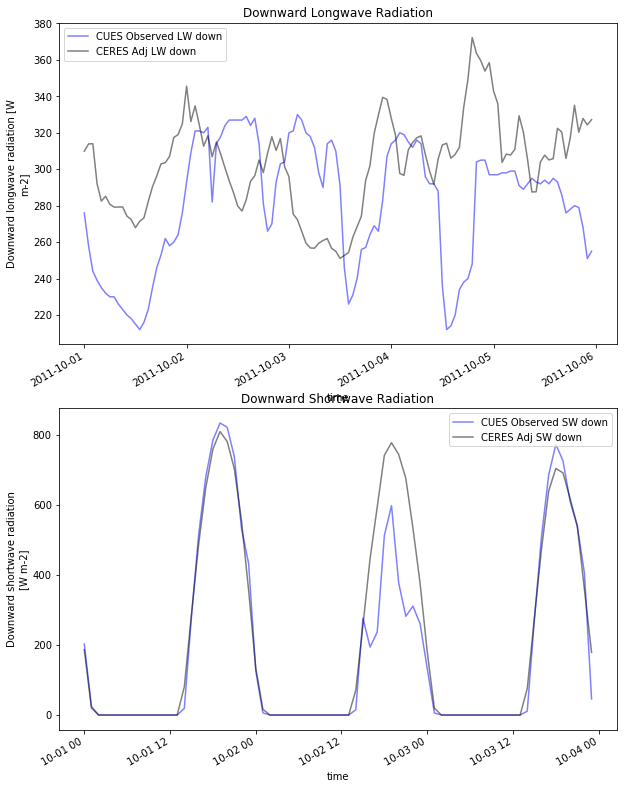

In [12]:
# close-up plots
year = 2011
fig, [ax1, ax2] = plt.subplots(2,1,figsize=(10,13))
cues_time_window.LWRadAtm.loc['{}-10-01'.format(year):'{}-10-05'.format(year)].plot(ax=ax1, color='b',linestyle='-',alpha=0.5,label='CUES Observed LW down')
cues_ceres.LWRadAtm.loc['{}-10-01'.format(year):'{}-10-05'.format(year)].plot(ax=ax1,color='k',linestyle='-',alpha=0.5,label='CERES Adj LW down')
ax1.set_title('Downward Longwave Radiation')
ax1.legend()
cues_time_window.SWRadAtm.loc['{}-10-01'.format(year):'{}-10-03'.format(year)].plot(ax=ax2, color='b',linestyle='-',alpha=0.5,label='CUES Observed SW down')
cues_ceres.SWRadAtm.loc['{}-10-01'.format(year):'{}-10-03'.format(year)].plot(ax=ax2,color='k',linestyle='-',alpha=0.5,label='CERES Adj SW down')
ax2.set_title('Downward Shortwave Radiation')
ax2.legend();
fig.savefig('in_phase.png')